In [ ]:
import torch 
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F 

import functools 
import operator 
import random 
import pickle 

import numpy as np 

from sklearn.metrics import confusion_matrix 
from torch.utils.data import TensorDataset 
from torch.utils.data import DataLoader 
from matplotlib import pyplot as plt 

In [368]:
# Exercise 1 
# Training data 
keepNew = True 
with open('PTB/ptb.train.txt', mode = 'r', newline = None) as train_f: 
    train_dat = train_f.read().splitlines(keepNew) 
    
# Validation data 
with open('PTB/ptb.valid.txt', mode = 'r', newline = None) as valid_f: 
    valid_dat = valid_f.read().splitlines(keepNew) 

# Testing data 
with open('PTB/ptb.test.txt', mode = 'r', newline = None) as test_f: 
    test_dat = test_f.read().splitlines(keepNew) 
    
# Printing examples phrases 
n_examp = np.random.choice(1000, size = 6, replace = False) 

print("Example training set phrase:", train_dat[n_examp[0]]) 
print("Example training set phrase:", train_dat[n_examp[1]]) 
print("Example validation set phrase:", valid_dat[n_examp[2]]) 
print("Example validation set phrase:", valid_dat[n_examp[3]]) 
print("Example test set phrase:", test_dat[n_examp[4]]) 
print("Example test set phrase:", test_dat[n_examp[5]]) 

# Adding <eos> 
train_proc, valid_proc, test_proc = [], [], [] 
for l_train in train_dat: 
    l_mod = l_train.replace('\n', '<eos>') 
    train_proc.append(l_mod) 
    
for l_valid in valid_dat: 
    l_mod = l_valid.replace('\n', '<eos>') 
    valid_proc.append(l_mod) 
    
for l_train in test_dat: 
    l_mod = l_train.replace('\n', '<eos>') 
    test_proc.append(l_mod) 
    
# Split up each line in individual words 
train_words, valid_words, test_words = [], [], [] 
for tp in train_proc: 
    train_words.append(tp.split()) 
    
for tp in valid_proc: 
    valid_words.append(tp.split()) 
    
for tp in test_proc: 
    test_words.append(tp.split()) 
    
# Flatten list of lists into a single list 
train_words = functools.reduce(operator.iconcat, train_words, []) 
valid_words = functools.reduce(operator.iconcat, valid_words, []) 
test_words = functools.reduce(operator.iconcat, test_words, []) 
    
num_train = len(train_words) 
num_valid = len(valid_words) 
num_test = len(test_words) 

print("Number of training words:", num_train) 
print("Number of validation words:", num_valid) 
print("Number of testing words:", num_test) 

# Building a dictionary 
all_words = train_words + valid_words + test_words 
set_words = set(all_words) 
num_unique = len(set_words) 

print("Number of unique words in training + validation + testing splits:", num_unique) 

num_id = np.random.choice(num_unique, size = num_unique, replace = False) 

n = 0 
unique_dict = {} 
for uw in set_words: 
    unique_dict.update({uw : num_id[n]}) 
    n += 1 
    
# Replacing all words in the training/validation/testing splits with their integer representation 
train_ints, valid_ints, test_ints = [], [], [] 

for word in train_words: 
    int_rep = unique_dict[word] 
    train_ints.append(int_rep) 

for word in valid_words: 
    int_rep = unique_dict[word] 
    valid_ints.append(int_rep) 
    
for word in test_words: 
    int_rep = unique_dict[word] 
    test_ints.append(int_rep) 

Example training set phrase:  against a shot of <unk> <unk> on an american flag an announcer talks about the strong tradition of freedom and individual liberty that <unk> have <unk> for generations 

Example training set phrase:  but yesterday 's factory orders report had good news on that front it said factory inventories fell N N in september the first decline since february N 

Example validation set phrase:  it is <unk> listening for the now generation 

Example validation set phrase:  the former board had produced N opinions and N critics in its 12-year life its chairman had conceded 

Example test set phrase:  brazil and venezuela are the only two countries that have n't completed steel talks with the u.s. for the year ending oct. N N 

Example test set phrase:  he has said that he now knows how justice john <unk> felt a reference to the late conservative justice who was the most frequent <unk> from the warren court 's opinions 

Number of training words: 929589
Number of validat

In [369]:
# Save the training/validation/testing splits + dictionary

In [370]:
# Loading the training/validation/testing splits + dictionary 

In [371]:
# Check if CUDA is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", torch.cuda.get_device_name(device)) 

Device: GeForce RTX 2080 Ti


In [372]:
# Resetting model function 
# Credits: https://discuss.pytorch.org/t/reset-model-weights/19180/4 
def reset_model(model):
    for layer in model.children(): 
       if hasattr(layer, 'reset_parameters'): 
           layer.reset_parameters() 

In [390]:
# Exercise 2 
# Convert our training/validation/testing splits to Torch tensors 
train_dat = torch.tensor(train_ints) 
valid_dat = torch.tensor(valid_ints) 
test_dat = torch.tensor(test_ints) 

# Generate training/validation/testing labels by shifting all integers (words) by one element in the list - shifting to the right 
#train_lab = torch.roll(train_dat, shifts = -1, dims = 0) 
#valid_lab = torch.roll(valid_dat, shifts = -1, dims = 0) 
#test_lab = torch.roll(test_dat, shifts = -1, dims = 0) 

### Data loading 
batch_size = 512 
batch_eval = 256  
seq_train = 5  
seq_valid = 20 
seq_test = 20 

s_train_l = num_train // seq_train 
s_valid_l = num_valid // seq_valid 
s_test_l = num_test // seq_test

# Trim training and validation data and reshape into tensor of num_sequences by sequence_length 
train_seq = torch.narrow(train_dat, 0, 0, seq_train * s_train_l) 
train_lab = torch.roll(train_seq, shifts = -1, dims = 0) 

train_seq = train_seq.reshape(s_train_l, seq_train)
train_lab_seq = train_lab.reshape(s_train_l, seq_train)

valid_seq = torch.narrow(valid_dat, 0, 0, seq_valid * s_valid_l)
valid_lab = torch.roll(valid_seq, shifts = -1, dims = 0) 

valid_seq = valid_seq.reshape(s_valid_l, seq_valid)
valid_lab_seq = valid_lab.reshape(s_valid_l, seq_valid)

print(train_dat) 
print()
print("Train seq:\n", train_seq)
print()
print("Train seq shape:\n", train_seq.shape)
print()
print("Train lab:\n", train_lab_seq)
print()
print("Train lab shape:\n", train_lab_seq.shape)
print()

# Divide training and validation data into correct mini-batches
num_batches = train_seq.shape[0] // batch_size 
valid_batches = valid_seq.shape[0] // batch_eval 

print(num_batches)
print()

#print(num_batches)
#print(valid_batches)

train_s = torch.narrow(train_seq, 0, 0, num_batches * batch_size)
train_s = train_s.reshape(-1, seq_train)

train_l = torch.narrow(train_lab_seq, 0, 0, num_batches * batch_size)
train_l = train_l.reshape(-1, seq_train)

print("Training batch:\n", train_s)
print("Training batch shape:\n", train_s.shape)
print() 
print("Training lab:\n", train_l) 
print() 
print("Training lab shape:\n", train_l.shape)
print() 
    
valid_s = torch.narrow(valid_seq, 0, 0, valid_batches * batch_eval) 
valid_s = valid_s.reshape(-1, seq_valid)   

valid_l = torch.narrow(valid_lab_seq, 0, 0, valid_batches * batch_eval)
valid_l = valid_l.reshape(-1, seq_valid)

# Moving training data and labels to GPU
train_s = train_s.to(device).long()
train_l = train_l.to(device).long() 

# Moving validation data and labels to GPU
valid_s = valid_s.to(device).long() 
valid_l = valid_l.to(device).long() 

training_set = TensorDataset(train_seq.to(device), train_lab_seq.to(device)) 
training_loader = DataLoader(training_set, shuffle = False, batch_size = num_batches) 

valid_set = TensorDataset(valid_seq.to(device), valid_lab_seq.to(device)) 
valid_loader = DataLoader(valid_set, shuffle = False, batch_size = valid_batches) 

tensor([8405, 6019, 6515,  ..., 7316, 4238, 9787])

Train seq:
 tensor([[8405, 6019, 6515, 7112,  310],
        [3689, 3266, 1365, 4118, 6274],
        [2804, 6942, 9618, 4529, 6661],
        ...,
        [1467, 4960, 7209, 4135, 7850],
        [7176, 2052, 9717, 7907, 5131],
        [1467,   91, 3040, 3837, 7365]])

Train seq shape:
 torch.Size([185917, 5])

Train lab:
 tensor([[6019, 6515, 7112,  310, 3689],
        [3266, 1365, 4118, 6274, 2804],
        [6942, 9618, 4529, 6661, 2120],
        ...,
        [4960, 7209, 4135, 7850, 7176],
        [2052, 9717, 7907, 5131, 1467],
        [  91, 3040, 3837, 7365, 8405]])

Train lab shape:
 torch.Size([185917, 5])

363

Training batch:
 tensor([[8405, 6019, 6515, 7112,  310],
        [3689, 3266, 1365, 4118, 6274],
        [2804, 6942, 9618, 4529, 6661],
        ...,
        [5263, 5985, 2466, 9787, 7316],
        [2466, 8402, 7332, 3991, 5865],
        [7846,  451, 5493, 2569, 4238]])
Training batch shape:
 torch.Size([185856, 5])

Trai

In [422]:
### RNN code  
# Embedding parameter 
embed_dim = 5 

# RNN parameters
hidden_dim = 5 
in_size = embed_dim 
n_layers = 2 

# Embedding layer 
#embed_layer = nn.Embedding(num_embeddings = num_unique, embedding_dim = embed_dim) 
#
# RNN layer 
#elman_rnn = nn.RNN(input_size = in_size, hidden_size = hidden_dim, num_layers = n_layers, batch_first = True) 
# Linear layer 
#linear_layer = nn.Linear(in_features = hidden_dim, out_features = num_unique) 

# Model 
class ElmanRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_embeddings, embedding_dim, hidden_dim, num_unique):
        super(ElmanRNN, self).__init__()
        
        self.input_size = input_size 
        self.hidden_size = hidden_size 
        self.num_layer = num_layers 
        self.num_embeddings = num_embeddings 
        self.embedding_dim = embedding_dim 
        
        self.embed = nn.Embedding(num_embeddings, embedding_dim)
        self.elman = nn.RNN(input_size, hidden_size, num_layers, batch_first = True) 
        self.linear = nn.Linear(hidden_dim, num_unique) 
        
    def forward(self, mod_input): 
        word_embed = self.embed(mod_input)
        rnn_out, hidden_out = self.elman(word_embed) 
        rnn_out = self.linear(rnn_out)
        rnn_out = rnn_out.view(-1, num_unique) 
        
        return rnn_out, hidden_out 
        
elm_mod = ElmanRNN(in_size, hidden_dim, n_layers, num_unique, embed_dim, hidden_dim, num_unique)
    
reset_model(elm_mod)
elm_mod.to(device) 

# Optimizer 
l_rate = 0.5
opt = optim.SGD(elm_mod.parameters(), lr = l_rate, weight_decay = 0, momentum = 0.0) 

# Cross entropy loss 
loss = nn.CrossEntropyLoss() 

# Training parameters 
num_epochs = 30 
train_epoch = np.zeros(num_epochs)
train_losss = [] 
valid_losss = [] 

valid_epoch = np.zeros(num_epochs) 

it = 0 

In [423]:
# Training 
for epoch in range(num_epochs):
    train_loss = np.zeros(num_batches) 
    valid_loss = np.zeros(valid_batches)
    #for it in range(num_batches): 
    for data, lab_train in training_loader: 
        elm_mod.train() 
        opt.zero_grad() 
    
        #inputs = train_s[(it*batch_size):((it+1)*batch_size), :] 
        #labels = train_l[(it*batch_size):((it+1)*batch_size), :] 
        
        pred_out, hid_out = elm_mod(data) 
        #print(pred_out.shape)
        #print(lab_train.shape)
        
        ce_loss = loss(pred_out, lab_train.flatten()) 
    
        train_loss[it] = ce_loss.item() 
        train_losss.append(ce_loss.item())
    
        ce_loss.backward() 
        opt.step() 
        
    train_epoch[epoch] = np.mean(train_loss) 
        
    #for it_eval in range(valid_batches):
    for data_eval, lab_eval in valid_loader: 
        elm_mod.eval() 
        
        #eval_in = valid_s[(it_eval*batch_eval):((it_eval+1)*batch_eval), :]
        #eval_lab = valid_l[(it_eval*batch_eval):((it_eval+1)*batch_eval), :]
        with torch.no_grad(): 
            valid_preds, valid_hid = elm_mod(data_eval) 
            
            ce_valid = loss(valid_preds, lab_eval.flatten()) 
            valid_loss[it_eval] = ce_valid.item() 
            valid_losss.append(ce_valid.item())
            
    valid_epoch[epoch] = np.mean(valid_loss) 
        
    #print("Epoch: %s" % (epoch + 1)) 

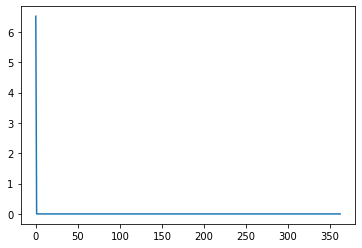

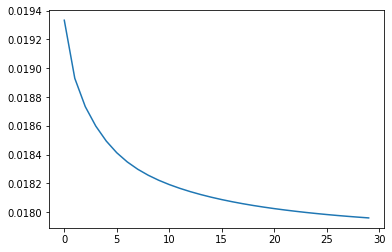

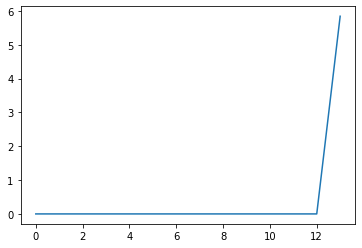

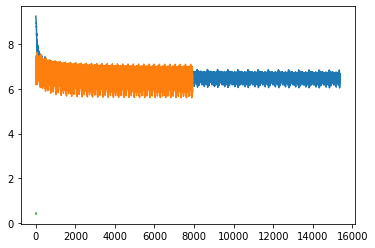

In [425]:
plt.figure(1) 
plt.plot(train_loss) 

plt.figure(2) 
plt.plot(train_losss) 

plt.figure(3) 
plt.plot(train_epoch) 

plt.figure(4) 
plt.plot(valid_loss) 

plt.figure(5) 
plt.plot(valid_losss) 

plt.figure(6) 
plt.plot(valid_epoch) 

In [ ]:
# Exercise 3 